## Assignment 5
Applying SVM as a Non-linear Classifier on CIFAR-10 Dataset

<i>Tasks:</i>

<b>Download and Load CIFAR-10 Dataset:</b>
Download the CIFAR-10 dataset from Kaggle and load it into the module.

<b>Pre-process Data:</b>
Clean up variables to prevent loading data multiple times.

<b>Print Data Sizes:</b>
Print the total output size of training and test samples to verify data loading.

<b>Visualize Training Data:</b>
Visualize some samples of training data using matplotlib.pyplot (plt).

<b>Apply Cross-validation:</b>
Split the data samples into train, test, and validation sets using cross-validation techniques.

<b>Create Development Set:</b>
Create a small development set as a subset of the training data to facilitate faster code execution.

<b>Display Data Shapes and Labels:</b>
Show the shapes of training, test, and validation data.
Display labels associated with each dataset.

<b>Pre-processing:</b>
Reshape the image samples into rows to prepare for SVM.

<b>Compute Mean Image:</b>
Compute the mean image after zero-centering the data.

<b>Zero-centering Data:</b>
Subtract the mean image from both training and testing data.

<b>Append Bias Dimension:</b>
Append a bias value of 1 to the data so that SVM optimizes only the weight matrix 
𝑊.

<b>Display Shapes of Data:</b>
Show the shapes of the training, test, and validation data after pre-processing.

<b>Apply SVM to Compute Loss:</b>
Apply SVM to compute the loss and gradients.

<b>Regularization and Gradient Calculation:</b>
Add regularization to the loss and compute the gradient of the loss with respect to the weight parameter.

In [ ]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
!pip install cupy-cuda110


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [5]:
y_train = y_train.flatten()
y_test = y_test.flatten()

print(f'Training labels shape: {y_train.shape}')
print(f'Test labels shape: {y_test.shape}')


Training labels shape: (50000,)
Test labels shape: (10000,)


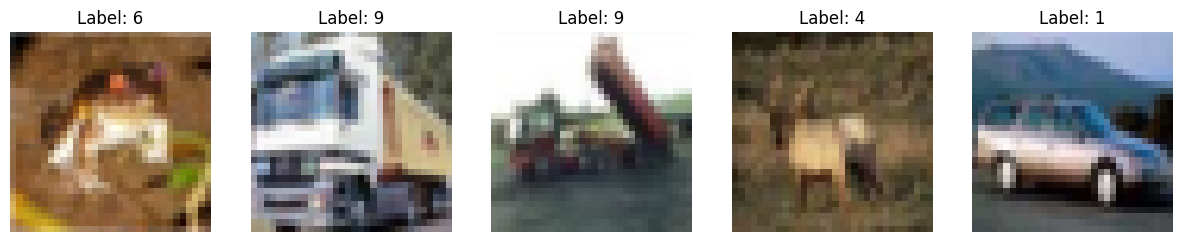

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(x_train[i])
    axes[i].set_title(f'Label: {y_train[i]}')
    axes[i].axis('off')
plt.show()


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f'Train data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')
print(f'Test data shape: {x_test.shape}')


Train data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [8]:
x_dev = x_train[:5000]
y_dev = y_train[:5000]

print(f'Development data shape: {x_dev.shape}')
print(f'Development labels shape: {y_dev.shape}')


Development data shape: (5000, 32, 32, 3)
Development labels shape: (5000,)


In [9]:
x_train = x_train.astype('float64')
x_val = x_val.astype('float64')
x_test = x_test.astype('float64')
x_dev = x_dev.astype('float64')

x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_dev_flat = x_dev.reshape(x_dev.shape[0], -1)

print(f'Flat train data shape: {x_train_flat.shape}')
print(f'Flat validation data shape: {x_val_flat.shape}')
print(f'Flat test data shape: {x_test_flat.shape}')
print(f'Flat development data shape: {x_dev_flat.shape}')


Flat train data shape: (40000, 3072)
Flat validation data shape: (10000, 3072)
Flat test data shape: (10000, 3072)
Flat development data shape: (5000, 3072)


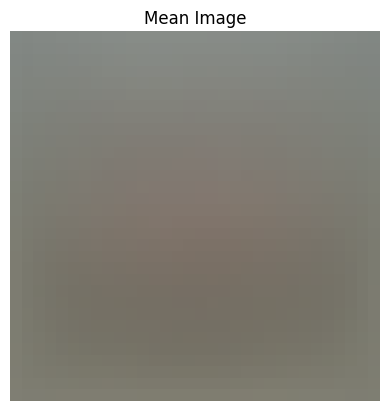

In [10]:
mean_image = np.mean(x_train_flat, axis=0)

x_train_flat -= mean_image
x_val_flat -= mean_image
x_test_flat -= mean_image
x_dev_flat -= mean_image

plt.imshow(mean_image.reshape(32, 32, 3).astype('uint8'))
plt.title('Mean Image')
plt.axis('off')
plt.show()


In [11]:
x_train_flat = np.hstack([x_train_flat, np.ones((x_train_flat.shape[0], 1))])
x_val_flat = np.hstack([x_val_flat, np.ones((x_val_flat.shape[0], 1))])
x_test_flat = np.hstack([x_test_flat, np.ones((x_test_flat.shape[0], 1))])
x_dev_flat = np.hstack([x_dev_flat, np.ones((x_dev_flat.shape[0], 1))])

x_test_flat=x_test_flat[0:1000]
y_test=y_test[0:1000]

print(f'Train data shape with bias: {x_train_flat.shape}')
print(f'Validation data shape with bias: {x_val_flat.shape}')
print(f'Test data shape with bias: {x_test_flat.shape}')
print(f'Development data shape with bias: {x_dev_flat.shape}')


Train data shape with bias: (40000, 3073)
Validation data shape with bias: (10000, 3073)
Test data shape with bias: (1000, 3073)
Development data shape with bias: (5000, 3073)


In [12]:
svm = SVC(kernel='linear', C=1)

x_train_flat=cp.array(x_train_flat)
y_train=cp.array(y_train)
x_test_flat=cp.array(x_test_flat)
y_test=cp.array(y_test)
x_val_flat=cp.array(x_val_flat)
y_val=cp.array(y_val)
x_dev_flat=cp.array(x_dev_flat)
y_dev=cp.array(y_dev)

svm.fit(x_dev_flat.get(), y_dev.get())

# train_acc = svm.score(x_train_flat.get(), y_train.get())
# val_acc = svm.score(x_val_flat.get(), y_val.get())
test_acc = svm.score(x_test_flat.get(), y_test.get())
dev_acc = svm.score(x_dev_flat.get(), y_dev.get())

# print(f'Training accuracy: {train_acc}')
# print(f'Validation accuracy: {val_acc}')
print(f'Test accuracy: {test_acc}')
print(f'Development accuracy: {dev_acc}')


Test accuracy: 0.301
Development accuracy: 1.0


In [13]:
# svm = SVC(kernel='linear', C=1)
# svm.fit(x_train_flat, y_train)

weights = svm.coef_
bias = svm.intercept_

print(f'Weights shape: {weights.shape}')
print(f'Bias shape: {bias.shape}')

Weights shape: (45, 3073)
Bias shape: (45,)


In [14]:
# !pip install -U dask-cudf cuml